In [1]:
from Genome.goldstandard_pair.lls import *
root_dir = '/home/hermuba/data0118/map_to_exist_net/EcoliNet/'
net = root_dir + 'ecoliNet_rm_plasmid'
gd = '/home/hermuba/data0118/goldstandard/tf_intersect_GO_rm_plasmidGO.smpl'

In [3]:
gold = read_gold(gd)
all_chunks = read_net_by_chunk(net)
all_chunk = merge_net_with_all_chunks(gold,all_chunks, 'EcoliNet')

In [4]:
all_chunk.shape

(1354, 5)

In [5]:
all_chunk.to_csv('~/data0118/EcoliNet_GO_smpl_rm_plasmid')

In [4]:
all_chunk.head()

,gene_one,gene_two,goldstandard,Unnamed: 0,Score
0,562.10576.con.0006_205|562.10576,562.22928.con.0007_120|562.22928,0,94559,0.801385
1,562.10576.con.0006_205|562.10576,562.23769.con.0004_161|562.23769,0,33871,2.346128
2,562.10576.con.0006_205|562.10576,FLWH01000015_58|562.12962,0,77800,1.210427
3,562.10576.con.0006_205|562.10576,JMUY01000004_30|1438670.3,0,52792,1.767220
4,562.10576.con.0006_205|562.10576,JMUY01000004_440|1438670.3,0,87615,0.958035


In [5]:
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')

In [6]:
# don't need to calculate LLS cause it's done.We need to change LLS threshold and calculate PPV and coverage
def PPV_coverage(lls_thres, all_df, total_nodes = gold_anno.shape[0]):
    '''
    calculate PPV, coverage using different threshold of LLS cutoff
    input: lls_thres: the LLS cutoff to consider interaction as True
    all_df: dataframe containing goldstandard and lls
    '''
    all_df['ans'] = all_df['Score'].map(lambda x: True if x > lls_thres else False)

    # calculate coverage
    total_nodes = set(all_df['gene_one']).union(set(all_df['gene_two']))
    net = all_df.loc[all_df['ans'] == True]
    
   
    covered_nodes = set(net['gene_one']).union(set(net['gene_two']))
    coverage = len(covered_nodes)/len(total_nodes)

    # calculate PPV
    grouped = all_df.groupby(by = ['goldstandard', 'ans']).count()['gene_one']

    try:
        tp = grouped[1, True]
        fp = grouped[0, True]
        PPV = tp/(tp+fp)
    except KeyError:
        PPV = 0
        
    return(coverage, PPV)

def try_diff_lls_thres(all_df):
    '''
    try different LLS threshold to see the tradeoffs between coverage and PPV
    LLS threshold as df['lls'].unique values
    all_df: dataframe containing goldstandard and lls
    '''
    tradeoff = pd.DataFrame(columns = ['thres', 'coverage', 'PPV'])
    
    max_score = all_chunk['Score'].max()
    min_score = all_chunk['Score'].min()
    try_list = np.linspace(start = min_score, stop = max_score, num = 50)
    
    for t in try_list:
        
        cov, PPV = PPV_coverage(t, all_df)
        tradeoff.loc[t] = [t, cov, PPV]
    return(tradeoff)


In [7]:
tradeoff = try_diff_lls_thres(all_chunk)

Text(0, 0.5, 'PPV')

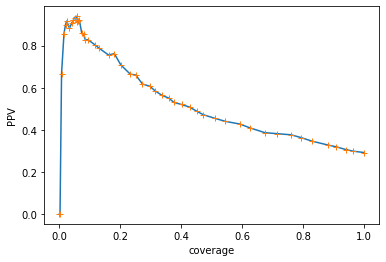

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '-')
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '+')
plt.xlabel('coverage')
plt.ylabel('PPV')

In [9]:
tradeoff.to_csv('~/data0118/PPV_coverage/EcoliNet')

# calculate statistic

In [10]:
core_genes = gold_anno.loc[gold_anno['core'] == True]
def net_stat(G):
    # core
    number_of_core = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['core'] == True].index))
    # accessory
    number_of_acc = G.number_of_nodes() - number_of_core
    # hypothetical
    number_of_hypo = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['hypo_nr'] == True].index))
    # mobile
    number_of_mobile = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_aclame'] == True].index))
    # CARD genes
    number_of_card = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_card'] == True].index))
    # COG annotation
    number_of_cog = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['cog_ID'].notna()].index))
    return([G.number_of_nodes(), 
            G.number_of_edges(), 
            nx.algorithms.components.number_connected_components(G),
           number_of_core,
           number_of_acc,
           number_of_hypo,
           number_of_mobile,
           number_of_card,
           number_of_cog])



In [11]:
import networkx as nx
G = nx.convert_matrix.from_pandas_edgelist(net, source = 'gene_one', target = 'gene_two')

TypeError: string indices must be integers

In [ ]:
net_stat(G)